# A Simple Text Analysis on Christmas Quotes from Literatures

Christmas is just around the corner, almost *literally*! If you want to spread the joy by coming up with quotes you can write in holiday cards for friends and family (or maybe as social media captions for your Christmas activities) but lack the inspirations to write one, I'm here to bring you text analysis on Christmas quotes from books for your inspiration. After all, what's a better place to find beautiful sayings than from books?

The dataset is taken from here: https://www.kaggle.com/ikpeleambrose/christmas-quotes

## Preparation

In [1]:
import re
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from pattern.en import lemma
from collections import Counter
%matplotlib inline

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')

In [3]:
# Load the file
df = pd.read_csv('data/christmas_quotes.csv')

In [4]:
df.head()

,quote,author,tags,likes
0,"One can never have enough socks,"" said Dumbled...",J.K. Rowling,albus-dumbledore books christmas desire family...,3741
1,Then the Grinch thought of something he hadn't...,Dr. Seuss,christmas,3145
2,The main reason Santa is so jolly is because h...,George Carlin,bad-girls christmas santa santa-claus sex,2304
3,"Mistletoe,"" said Luna dreamily, pointing at a ...",J.K. Rowling,christmas humor,1433
4,"How many observe Christ's birthday! How few, H...",Benjamin Franklin,christian-behavior christmas religion,855


## General Overview

In [5]:
# Count the number of authors
cnt_authors_df = df.groupby('author').agg({'quote':'count', 'likes':'sum'}).sort_values(by='quote', ascending=False).rename(columns={'quote':'count'}).reset_index()

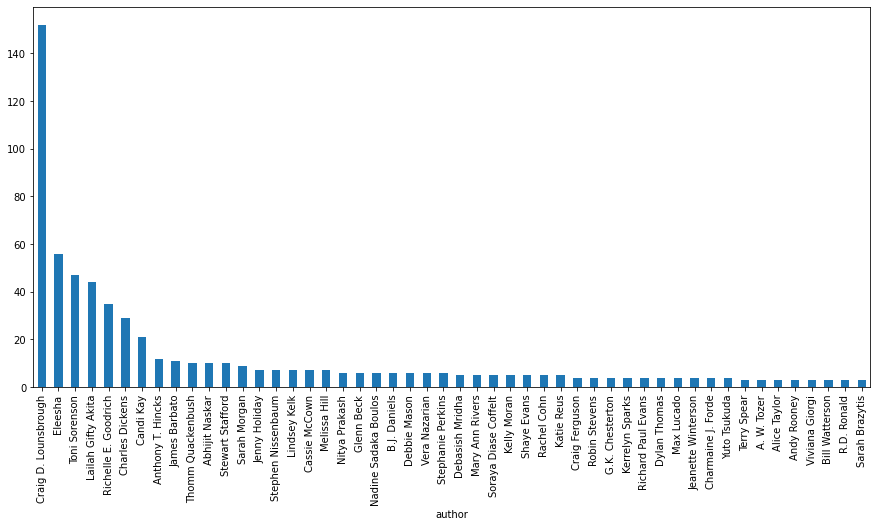

In [6]:
# Plot by author count
cnt_authors_df.sort_values(by='count', ascending=False).head(50).plot(kind='bar', x='author', y='count', figsize=(15,7), legend=False)
plt.show()

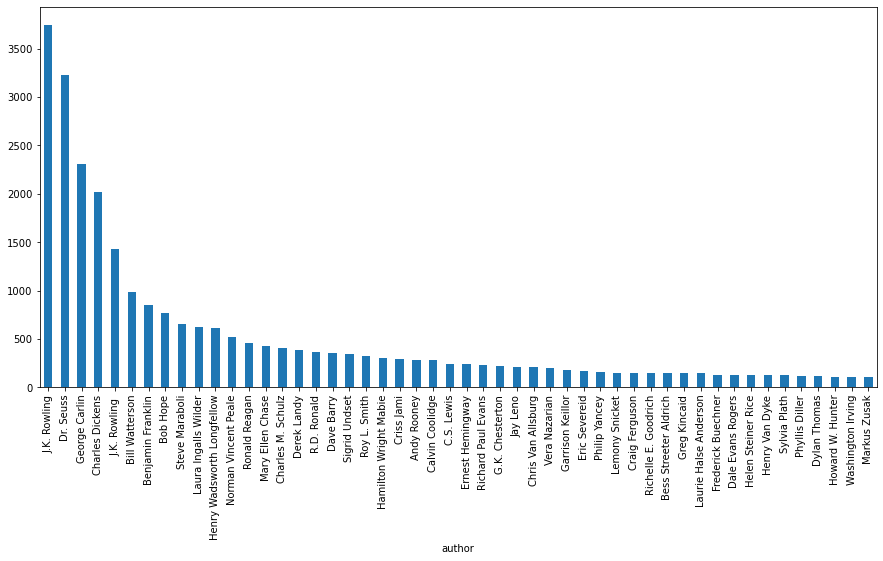

In [7]:
# Plot by author likes
cnt_authors_df.sort_values(by='likes', ascending=False).head(50).plot(kind='bar', x='author', y='likes', figsize=(15,7), legend=False)
plt.show()

In [8]:
df['tags'] = df['tags'].apply(lambda row: row.split(" "))

In [9]:
df.head()

,quote,author,tags,likes
0,"One can never have enough socks,"" said Dumbled...",J.K. Rowling,"[albus-dumbledore, books, christmas, desire, f...",3741
1,Then the Grinch thought of something he hadn't...,Dr. Seuss,[christmas],3145
2,The main reason Santa is so jolly is because h...,George Carlin,"[bad-girls, christmas, santa, santa-claus, sex]",2304
3,"Mistletoe,"" said Luna dreamily, pointing at a ...",J.K. Rowling,"[christmas, humor]",1433
4,"How many observe Christ's birthday! How few, H...",Benjamin Franklin,"[christian-behavior, christmas, religion]",855


In [10]:
all_tags = []
for tag in df['tags']:
    all_tags.extend(tag)
    
cnt_tags = Counter(all_tags)
cnt_tags_df = pd.DataFrame.from_dict(cnt_tags, orient='index').reset_index().rename(columns={'index':'tag', 0:'count'})

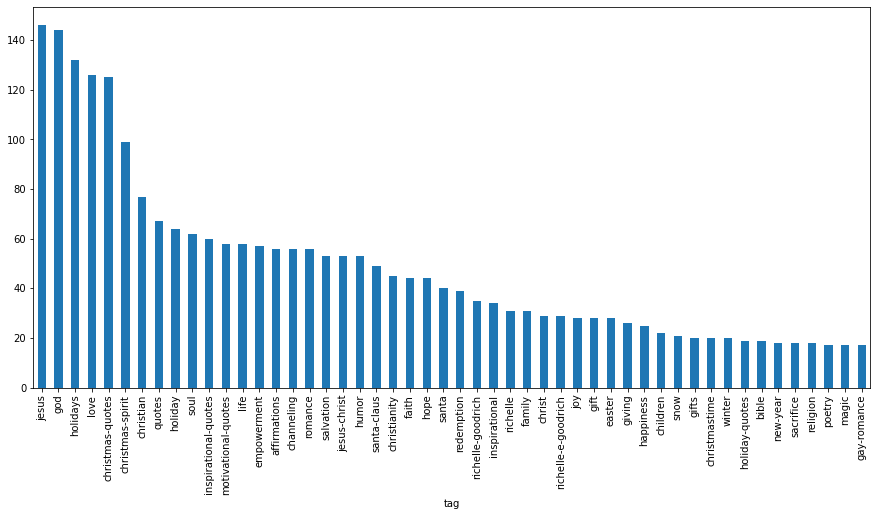

In [11]:
tmp = cnt_tags_df[cnt_tags_df['tag'] != 'christmas']
tmp.sort_values(by='count', ascending=False).head(50).plot(kind='bar', x='tag', y='count', figsize=(15,7), legend=False)
plt.show()

## Text Analysis

In [12]:
# Take only the quotes
df = df.drop(['author', 'tags', 'likes'], axis=1)

# Separate the quotes by sentence
sentence_end = ['.', '!', '?']

for punctuation in sentence_end:
    df['quote'] = df['quote'].apply(lambda row: row.split(punctuation))
    df = df.explode('quote')

df = df[df['quote'] != '']

In [14]:
df.head()

,quote_id,quote
0,1,"One can never have enough socks,"" said Dumbledore"
0,1,"""Another Christmas has come and gone and I di..."
0,1,People will insist on giving me books
1,2,Then the Grinch thought of something he hadn't...
1,2,"What if Christmas, he thought, doesn't come f..."


In [15]:
# Tokenize each word from the sentences
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^\w^\'\d-]", " ", text)
    text = re.sub(r"[ ]{2,}", " ", text)
    text = word_tokenize(text)
    return text

df['quote_tokenized'] = df['quote'].apply(lambda row: tokenize(row))

In [16]:
df.head()

,quote_id,quote,quote_tokenized
0,1,"One can never have enough socks,"" said Dumbledore","[one, can, never, have, enough, socks, said, d..."
0,1,"""Another Christmas has come and gone and I di...","[another, christmas, has, come, and, gone, and..."
0,1,People will insist on giving me books,"[people, will, insist, on, giving, me, books]"
1,2,Then the Grinch thought of something he hadn't...,"[then, the, grinch, thought, of, something, he..."
1,2,"What if Christmas, he thought, doesn't come f...","[what, if, christmas, he, thought, does, n't, ..."


In [17]:
# Create list of stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(['christmas', 'said', 'asked', 'shouted', 'yelled', 'n\'t', '\'s', 'instead', 'finally', 'later', 'soon', 'place', 'one', 'thing', 'something', '-', 'would', 'actually', 
                   'throughout', 'must', 'much', 'many', 'everything', 'every', 'thing', 'ന', 'never', 'ക', 'be'])

In [22]:
# Filter stopwords
def filter_stopwords(text):
    filtered_text = [word for word in text if not word in stop_words]
    return filtered_text

df['quote_filtered'] = df['quote_tokenized'].apply(lambda row: filter_stopwords(row))

In [23]:
# Lemmatize each word
def lemmatizer(row):
    word_list = []
    for word in row:
        lemmatized = lemma(word)
        # Ensure words that don't have to be lemmatized don't get lemmatized
        if lemmatized in dict_list:
            word = lemmatized
        else:
            word = word
        word = word.replace('\'', '')
        word_list.append(word)
    return word_list

dict1 = pd.read_excel("dict/english-dict.xlsx", sheet_name='common-verbs', header=None)
dict2 = pd.read_excel("dict/english-dict.xlsx", sheet_name='nouns', header=None)
dict_list = pd.concat([dict1, dict2])[0].to_list()

df['quote_lemmatized'] = df['quote_filtered'].apply(lambda row: lemmatizer(row))

# Filter the lemmatized words *again* in case we miss something
df['quote_lemmatized'] = df['quote_lemmatized'].apply(lambda row: lemmatizer(row))

In [24]:
# Count number of words
word_list = []
for text in df['quote_lemmatized']:
    [word_list.append(word) for word in text]

cnt_words = Counter(word_list)
cnt_words_df = pd.DataFrame.from_dict(cnt_words, orient='index').reset_index().rename(columns={'index':'word', 0:'count'})

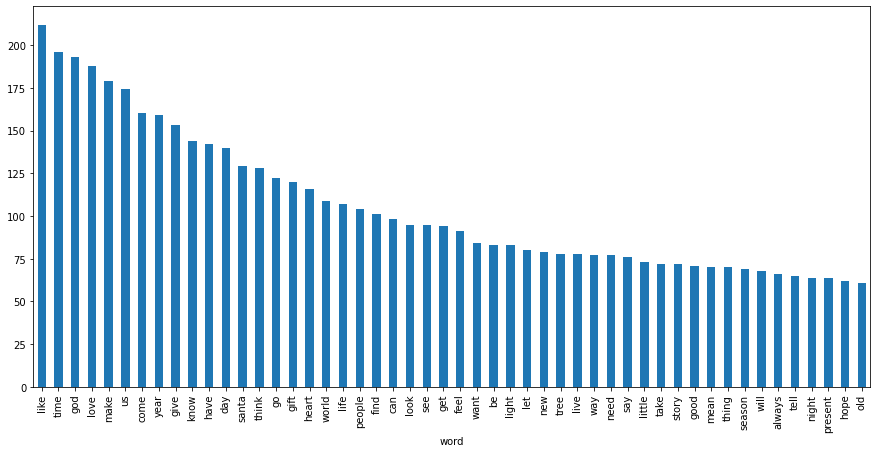

In [26]:
# Plot count of words
cnt_words_df.sort_values(by='count', ascending=False).head(50).plot(kind='bar', x='word', y='count', figsize=(15,7), legend=False)
plt.show()

In [27]:
# Create a sentence list that doesn't include repeated words
sentence_list = []
for word in df['quote_lemmatized']:
    res = []
    [res.append(x) for x in word if x not in res]
    sentence_list.append(res)

In [28]:
# Generate a sentence-based word pair list
pair_list = [
             list(itertools.combinations(word, 2))
             for word in sentence_list if len(sentence_list) >=2
             ]

# Flatten the word pair list
all_pairs = []
for sentence in pair_list:
        for pair in sentence:
            pair = tuple(sorted(list(pair)))
            all_pairs.append(pair)
    
# Count the frequency of word pairs
cnt_pairs = Counter(all_pairs)

In [51]:
# Only take top 30 pairs
tops = sorted(
    cnt_pairs.items(), 
    key=lambda x: x[1], reverse=True
    )[:35]

In [52]:
# Create pairs dataframe and weighted edges array
pairs_df = pd.DataFrame(tops, columns=['pair', 'count'])
pairs_df['word 1'] = pairs_df['pair'].apply(lambda row: row[0])
pairs_df['word 2'] = pairs_df['pair'].apply(lambda row: row[1])
pairs_df = pairs_df[['word 1', 'word 2', 'count']]
min_count = pairs_df['count'].min()
pairs_df['weight'] = pairs_df['count']/min_count
weighted_edges = np.array(pairs_df[['word 1', 'word 2', 'weight']])

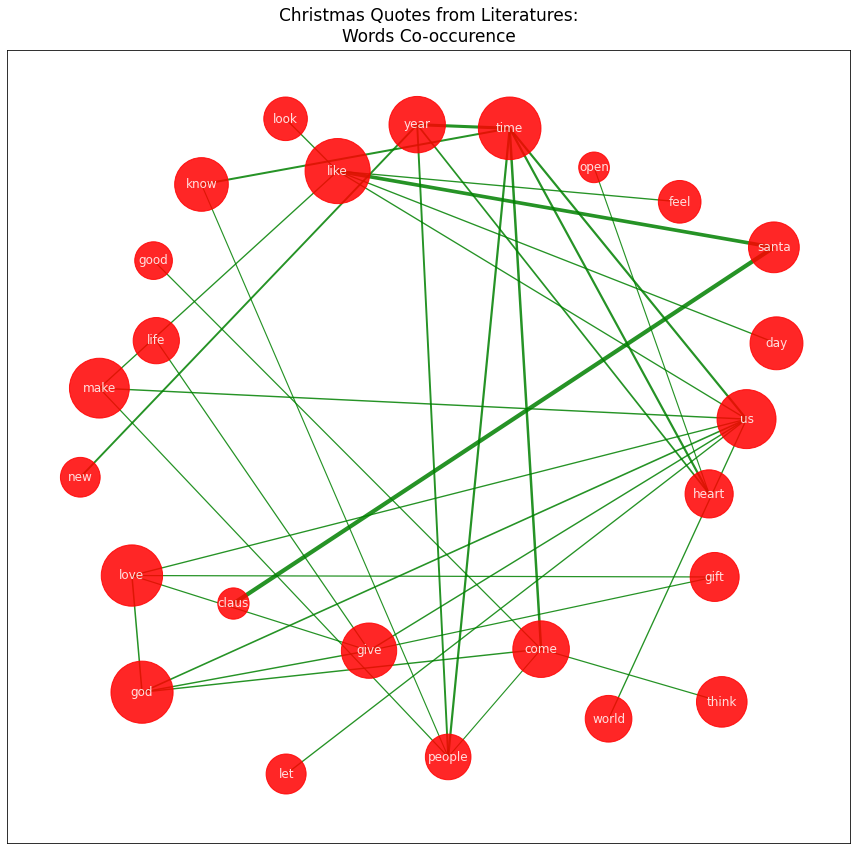

<Figure size 432x288 with 0 Axes>

In [58]:
# Generate a graph object
G = nx.Graph()

# Read weighted data
G.add_weighted_edges_from(weighted_edges)
pos = nx.spring_layout(G, k=3, iterations=15)
# pos = nx.circular_layout(G)

# Widths
widths = [float(number*1.15) for number in pairs_df['weight']]

# Sizes
nodes_count = pd.DataFrame(G.nodes(), columns=['word']).merge(cnt_words_df, how='left', on='word')
sizes = [number*20 for number in nodes_count['count']]

# Draw a network diagram
plt.figure(figsize=(12,12))
ax = plt.gca()
plt.suptitle('Christmas Quotes from Literatures:\nWords Co-occurence', fontsize=17, ha="center")
values = range(7)
nx.draw_networkx(G,
                 pos=pos,
                 node_color = "red", 
                 node_size = sizes,
                 width = widths,
                 edge_color = "green",
                 alpha = 0.85,
                 font_size = 12,
                 font_color = 'white',
                 ax=ax)

plt.tight_layout()
plt.show()
plt.savefig('xmas-cooccurence.png')